In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO

# For downloading images
import os
import urllib

In [2]:
#bot_keyboard
import pandas as pd
column_names = ["BKEYTime", "BKEYAction", "BKEYX_Coordinate", "BKEYY_Coordinate"]
bot_keyboard = pd.read_csv(r"bot_keyboard.txt", sep=",", names=column_names, skiprows=1)
print(bot_keyboard.head())

   BKEYTime BKEYAction  BKEYX_Coordinate  BKEYY_Coordinate
0   10928.6    Pressed               758               348
1   10934.8       Move               758               348
2   11035.2       Move               758               350
3   11052.5       Move               756               350
4   11069.2       Move               756               351


In [3]:
#bot_naturalmouse
import pandas as pd
column_names1 = ["BMOUSETime", "BMOUSEAction", "BMOUSEX_Coordinate", "BMOUSEY_Coordinate"]
bot_naturalmouse = pd.read_csv(r"bot_naturalmouse.txt", sep=",", names=column_names1, skiprows=1)
print(bot_naturalmouse.head())

   BMOUSETime BMOUSEAction  BMOUSEX_Coordinate  BMOUSEY_Coordinate
0     38593.0      Pressed                 825                 436
1     38609.3         Move                 825                 436
2     38621.0         Move                 825                 436
3     38821.7         Move                 825                 436
4     38837.7         Move                 825                 436


In [4]:
#human_vm
import pandas as pd
column_names2 = ["HTime", "HAction", "HX_Coordinate", "HY_Coordinate"]
human_vm = pd.read_csv(r"humanpv.txt", sep=",", names=column_names2, skiprows=1)
print(human_vm.head())

   HTime  HAction  HX_Coordinate  HY_Coordinate
0  39196  Pressed            785            135
1  39216     Move            782            133
2  39221     Move            780            133
3  39245     Move            775            130
4  39252     Move            773            130


In [5]:
bot_keyboard['label'] = 0
bot_naturalmouse['label'] = 0
human_vm['label'] = 1

In [6]:
import pandas as pd
column_names = ["BKEYTime", "BKEYAction", "BKEYX_Coordinate", "BKEYY_Coordinate"]
bot_keyboard = pd.read_csv(r"bot_keyboard.txt", sep=",", names=column_names, skiprows=1)
column_names1 = ["BMOUSETime", "BMOUSEAction", "BMOUSEX_Coordinate", "BMOUSEY_Coordinate"]
bot_naturalmouse = pd.read_csv(r"bot_naturalmouse.txt", sep=",", names=column_names1, skiprows=1)
column_names2 = ["HTime", "HAction", "HX_Coordinate", "HY_Coordinate"]
human_vm = pd.read_csv(r"humanpv.txt", sep=",", names=column_names2, skiprows=1)

bot_keyboard.reset_index(drop=True, inplace=True)
bot_naturalmouse.reset_index(drop=True, inplace=True)
human_vm.reset_index(drop=True, inplace=True)

combined_df = pd.concat([bot_keyboard, bot_naturalmouse, human_vm], axis=1)
print(combined_df.head())


   BKEYTime BKEYAction  BKEYX_Coordinate  BKEYY_Coordinate  BMOUSETime  \
0   10928.6    Pressed             758.0             348.0     38593.0   
1   10934.8       Move             758.0             348.0     38609.3   
2   11035.2       Move             758.0             350.0     38621.0   
3   11052.5       Move             756.0             350.0     38821.7   
4   11069.2       Move             756.0             351.0     38837.7   

  BMOUSEAction  BMOUSEX_Coordinate  BMOUSEY_Coordinate    HTime  HAction  \
0      Pressed                 825                 436  39196.0  Pressed   
1         Move                 825                 436  39216.0     Move   
2         Move                 825                 436  39221.0     Move   
3         Move                 825                 436  39245.0     Move   
4         Move                 825                 436  39252.0     Move   

   HX_Coordinate  HY_Coordinate  
0          785.0          135.0  
1          782.0          133.

In [7]:
combined_df['BKEYAction'].value_counts()

BKEYAction
Move        94
Released     2
Pressed      1
Name: count, dtype: int64

In [8]:
combined_df['BMOUSEAction'].value_counts()

BMOUSEAction
Move        400
Released      2
Pressed       1
Name: count, dtype: int64

In [9]:
combined_df['HAction'].value_counts()

HAction
Move        58
Released     2
Pressed      1
Name: count, dtype: int64

In [10]:
len_bot_keyboard = len(bot_keyboard)
len_bot_naturalmouse = len(bot_naturalmouse)
len_human_vm = len(human_vm)

print(f"Length of bot_keyboard: {len_bot_keyboard}")
print(f"Length of bot_naturalmouse: {len_bot_naturalmouse}")
print(f"Length of human_vm: {len_human_vm}")



Length of bot_keyboard: 97
Length of bot_naturalmouse: 403
Length of human_vm: 61


In [11]:
# Truncate the datasets to the length of combined_df
length_combined = len(combined_df)
bot_naturalmouse = bot_naturalmouse.iloc[:length_combined]

In [12]:
if len(bot_keyboard) < length_combined:
    # Interpolate or repeat rows
    bot_keyboard = bot_keyboard.reindex(range(length_combined), method='ffill')  # Forward fill

# For human_vm (shorter)
if len(human_vm) < length_combined:
    # Interpolate or repeat rows
    human_vm = human_vm.reindex(range(length_combined), method='ffill')  # Forward fill


In [26]:
# Assuming bot_naturalmouse already has the correct length
combined_df = pd.concat([bot_keyboard, bot_naturalmouse, human_vm], axis=1)

In [27]:
# Create labels
label_bot_keyboard = [0] * len(bot_keyboard)
label_bot_naturalmouse = [0] * len(bot_naturalmouse)
label_human_vm = [1] * len(human_vm)

# Combine labels
labels = label_bot_keyboard + label_bot_naturalmouse + label_human_vm
labels = labels[:length_combined]  # Truncate or extend to match length_combined

# Add labels to DataFrame
combined_df['label'] = labels


In [30]:
from sklearn.preprocessing import LabelEncoder

# Define features and target variable
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Convert non-numeric columns to numeric
categorical_cols = X.select_dtypes(include=['object']).columns
le = LabelEncoder()

for col in categorical_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Check for and handle missing values
X = X.ffill().bfill()

# Ensure y is numeric
y = y.astype(int)


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121


Confusion Matrix:
[[121]]


C:\Users\Roshika\demo\Demo\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


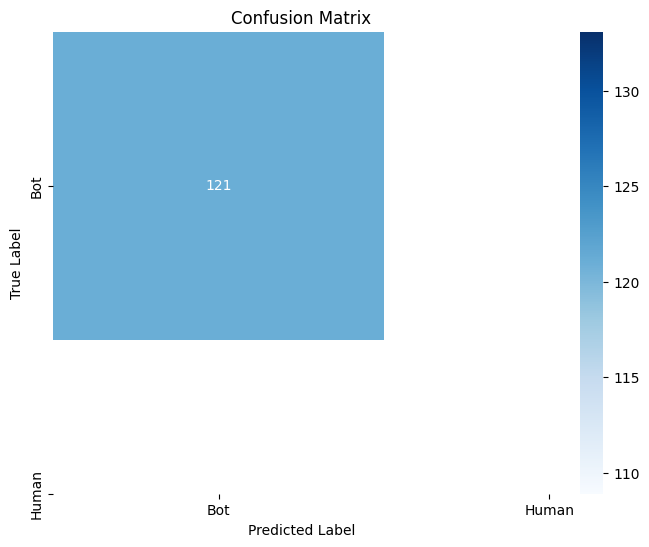


Feature Ranking:
1. feature HY_Coordinate (0.0000)
2. feature HX_Coordinate (0.0000)
3. feature HAction (0.0000)
4. feature HTime (0.0000)
5. feature BMOUSEY_Coordinate (0.0000)
6. feature BMOUSEX_Coordinate (0.0000)
7. feature BMOUSEAction (0.0000)
8. feature BMOUSETime (0.0000)
9. feature BKEYY_Coordinate (0.0000)
10. feature BKEYX_Coordinate (0.0000)
11. feature BKEYAction (0.0000)
12. feature BKEYTime (0.0000)


In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bot', 'Human'], yticklabels=['Bot', 'Human'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Feature importance (Optional)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("\nFeature Ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]:.4f})")
